# Financial Exploratory Analysis

This exploratory analysis seeks to better understand issues and relationships surrounding financial trades. The data sources are from two categories: public domain financial data and textual data. 

In [1]:
#from financialexploratoryanalysis import data

In [2]:
%matplotlib inline
import bs4 as bs
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pandas_datareader.data as web
import pickle
import requests
from urllib.request import urlretrieve

style.use('ggplot')


In [3]:
# Scrape S&P 500 tickers from Wikipedia for a local reference
def save_sp500_tickers():
    """Get the S&P 500 tickers from Wikipedia"""
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, "lxml")
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        # fix for . and - tickers
        mapping = str.maketrans(".","-")
        ticker = ticker.translate(mapping)
        tickers.append(ticker)
    
    # cache the results for local access
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    
    #print(tickers)
    return tickers

In [4]:
# Collect the ticker data using Yahoo finance API
def get_data_from_yahoo(reload_sp500=False):
    """Collect all the S&P500 transactional data from Yahoo.
    
    Parameters
    ----------
    reload_sp500 : bool
    
    Return
    ------
    tickers : list
    
    """
    if reload_sp500:
        tickers = pickle.load(f)
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2018,12,31)
    
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already cached {}'.format(ticker))
    

In [5]:
#get_data_from_yahoo()

In [6]:
# Merge the transactional data into single DataFrame
def compile_data():
    """Merge all the stock data into single DataFrame"""
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        df.rename(columns = {'Adj Close':ticker}, inplace=True)
        df.drop(['Open','High','Low','Close','Volume'], 1, inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
        
        if count % 10 == 0:
            print(count)
        
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
    

In [7]:
#compile_data()

## Exploratory analysis for relationships in the data

In [8]:
# 
def visualize_data():
    """Large correlation plot"""
    df = pd.read_csv('sp500_joined_closes.csv')
    #df['AAPL'].plot()
    #plt.show()
    df_corr = df.corr()
    
    #print(df_corr.head())
    
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    

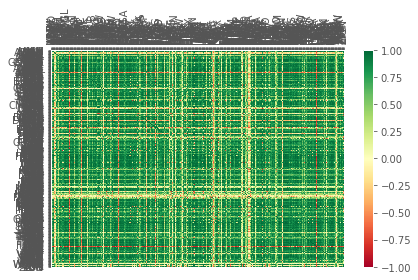

In [9]:
visualize_data()

In [10]:
# Preprocessing for ML modeling
from collections import Counter
from sklearn import svm, model_selection as cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

def process_data_for_labels(ticker):
    """blah"""
    predict_days = 7  # predict future price in days
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1, predict_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    
    df.fillna(0, inplace=True)
    return tickers, df

In [11]:
#process_data_for_labels('BAC')

In [12]:
def buy_sell_hold(*args):
    """blah"""
    cols = [c for c in args]
    requirement = 0.02  # 2% change fires buy or sell trigger
    for col in cols:
        if col > requirement:
            return 1  # buy
        if col < requirement:
            return -1  # sell
    return 0

In [13]:
# 
def extract_bsh_featuresets(ticker):
    """blah"""
    tickers,df = process_data_for_labels(ticker)
    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)]
                                               ))
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread: ', Counter(str_vals))
    
    df.fillna(0, inplace=True)
    df - df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()  # normalize the values
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    # X are featuresets, y are labels
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df

In [14]:
#extract_bsh_featuresets('AAPL')

In [15]:
# ML Classifier
def do_ml(ticker):
    """blah"""
    X, y, df = extract_bsh_featuresets(ticker)
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    clf = neighbors.KNeighborsClassifier()
    
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    predictions = clf.predict(X_test)
    
    print('Predicted spread: ', Counter(predictions))
    print('Accuracy: ', confidence)
    
    return confidence
    

In [16]:
do_ml('BAC')

Data spread:  Counter({'-1': 4165, '1': 614})
Predicted spread:  Counter({-1: 1187, 1: 8})
Accuracy:  0.8702928870292888


0.8702928870292888